# Problem set 1, Asymmetric loss regression

First, Let's load the data and plot the training data out.

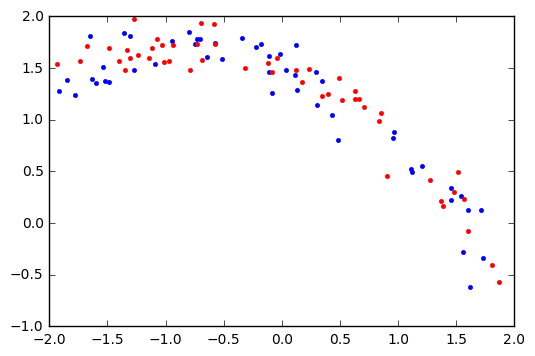

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
from utils import *  # this loads definitions of functions etc. in utils.py provided with the assignment
import pylab

# Load data
X_train, y_train = loadData('train')
X_val, y_val = loadData('val')

pylab.plot(X_train, y_train, '.')
pylab.plot(X_val, y_val, 'r.')


First, we will solve the linear regression (under the "normal" symmetric squared loss) using the closed form solution. Let's define a couple of functions we will need.

In [17]:
def symmLoss(X, w ,y):
    """
    Get the symmetric squared loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    loss : a scalar
        The loss calculated by the symmetric loss formula
    """
    return np.mean((y-np.dot(X,w))**2) #YOUR CODE HERE

In [4]:
def lsqClosedForm(X, y):
    """
    Use closed form solution for least squares minimization

    Parameters
    ----------
    X : 2D array
        N x d+1 data matrix (row per example)
    y : 1D array
        Observed function values

    Returns
    -------
    w : 1D array
        d+1 length vector
    """
    return np.dot(np.linalg.pinv(X), y)

Test the closed form solution: generate a toy data set from a random linear function with no noise. We should be able to perfectly recover w in this case (up to numerical precision).

In [5]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:  '+repr(w))
w_ = lsqClosedForm(X, y)
print('function output: '+repr(w_))
if (np.allclose(w,w_)):
    print('Close enough')


true weight:  array([ 0.42396084,  0.44673039])
function output: array([ 0.42396084,  0.44673039])
Close enough


The function to estimate the variance of the noise and the log likelihood of the data.

In [20]:
def logLikelihood(X, w, y):
    """
    Get the estimated variance, and the log likelihood of the data

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values

    Returns
    -------
    simga2 : a scalar
        The estimated variance (sigma squared)
    loglike : a scalar
        The log-likelihood under the Gaussian noise model N(0,sigma2)
    """
    N = X.shape[0]   # number of rows in X
    # now estimate the variance of the Gaussian noise (sigma2 stands for \sigma^2)
    sigma2 = np.var(y-np.dot(X,w)) #YOUR CODE HERE
    # normalized log-likelihood (mean of per-data point log-likelihood of the model given by w,sigma2)
    loglike = - 1 / 2.0 * np.log(2*np.pi*sigma2) - np.mean((np.dot(X, w) - y)**2) / (sigma2 * 2)
    return sigma2, loglike

Now let's fit linear, quadratic and cubic models to the training data, and plot the fit function.

degree 1:
train loss 0.155770
val loss 0.108249
sigma^2: 0.155770 
log-likelihood -0.489250

degree 2:
train loss 0.032250
val loss 0.024095
sigma^2: 0.032250 
log-likelihood 0.298185

degree 3:
train loss 0.031714
val loss 0.026440
sigma^2: 0.031714 
log-likelihood 0.306554



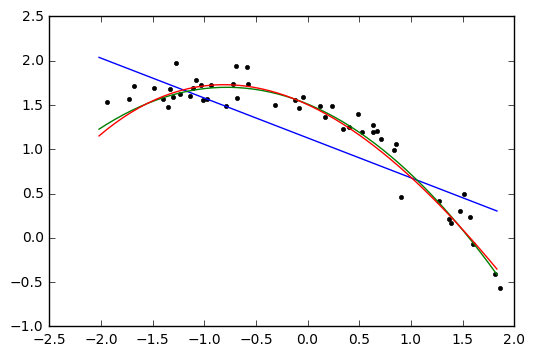

In [21]:
min_loss = np.Inf
pylab.plot(X_val, y_val, 'k.')

# Try degree 1 to 3
for deg in [1,2,3]:
    # Expand data first; you can check how this function works in utils.py
    X, C = degexpand(X_train, deg)
    
    # Get the result by applying normal equation
    w = lsqClosedForm(X, y_train)
    
    # compute loss on training
    loss = symmLoss(X, w, y_train)
    
    # compute loss on val; note -- use the same scaling matrix C as for training
    val_loss = symmLoss(degexpand(X_val, deg, C)[0], w, y_val)
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f' %(val_loss))
    print('sigma^2: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y_train))
    
    if val_loss < min_loss:
        min_loss = val_loss
        # record in best_param the model weights, degree, and the scaling matrix of the best model so far
        best_param = (w, deg, C)
    
    # Plot the function
    color = {1:'b', 2:'g', 3:'r'}[deg]
    pylab.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color)


In [46]:
# Announce result on test data
X_test, y_test = loadData('test')
print("Best degree:"+repr(best_param[1]))
#YOUR CODE HERE TO PRINT RELEVANT EVALUATION METRIC FOR THE CHOSEN MODEL
test_loss = symmLoss(degexpand(X_test, best_param[1], best_param[2])[0],best_param[0], y_test)
print('test loss %.6f' %(test_loss))




Best degree:2
test loss 0.072769


Now we want to repeat the experiment above but under the asymmetric loss function. Since there is no closed form solution, we will need to rely on gradient descent. First we need to implement the loss function and the gradient function.

In [25]:
def asymmLoss(X, w, y,alpha):
    """
    Get the asymmetric loss given data X, weight w and ground truth y

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values
    alpha : scalar
        weight put on positive error, i.e., yhat > y

    Returns
    -------
    loss : a scalar
        The loss calculated by equation in problem set 1
    """
    
    # it may be more convenient to define the loss as a per-data point weighted loss,
    # with weights determined by the sign of the error and collected into a diagonal matrix
    
    N = X.shape[0]
    yhat = np.dot(X, w)
    weights=np.zeros([N,N])
    for i in range(0,N):
        if yhat[i] > y[i]:
            weights[i][i] = alpha
        else:
            weights[i][i] = 1
    loss = np.mean(np.dot(weights,(y-np.dot(X,w))**2))  #YOUR CODE HERE
    return loss
    

In [30]:
def asymmGrad(X, w, y,alpha):
    """
    Get the gradient of w

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    w : 1D array
        d+1 length vector
    y : 1D array
        Observed function values
    alpha : scalar
        weight put on positive error, i.e., yhat > y

    Returns
    -------
    grad : 1D array
        d+1 length vector
    """
    N = X.shape[0]
    yhat = np.dot(X,w)
    # use the weights here as well, defined by alpha
    weights=np.zeros([N,N])
    for i in range(0,N):
        if yhat[i] > y[i]:
            weights[i][i] = alpha
        else:
            weights[i][i] = 1
    grad = (1/N)*(-2*((X.T).dot(weights)).dot(y) + 2*((X.T).dot(weights).dot(X).dot(w))) #YOUR CODE HERE
    return grad

Test the loss and gradient function. You can manually verify that for the given values of X (2 data points), y and w, with alpha=10, you should get these numbers for the objective (asymmetric loss) value and for the gradient. Then, run the code to make sure your implementation of the gradient is correct.

In [31]:
loss, grad = asymmLoss(np.array([[1,2], [1, -2]]), np.array([1,1]), np.array([4, -2]),10), \
            asymmGrad(np.array([[1,2], [1, -2]]), np.array([1,1]), np.array([4, -2]),10)
print("expected output")
print("5.5")
print("[ 9 -22]")
print("function output:")
print(loss)
print(grad)

expected output
5.5
[ 9 -22]
function output:
5.5
[  9. -22.]


Since we have had the functions to calculate loss and gradient, we can implement the gradient descent algorithm.

In [33]:
def gradDescent(X, y,alpha,tol=1e-4,maxIt=10000):
    """
    Use gradient descent to min(loss(X, w, y))

    Parameters
    ----------
    X : 2D array
        N x d+1 design matrix (row per example)
    y : 1D array
        Observed function values

    Returns
    -------
    w : 1D array
        d+1 length vector
        
    it: number of iterations until convergence
    """
    # Random initialize the weight
    w = np.random.randn(X.shape[1])
    lr = 0.01 # learning rate (make it constant 0.01; feel free to experiment with the value)
    it = 0 # iteration count
    lastloss = np.Inf # loss computed at previous check point
    checkit = 500 # interval to check convergence
    while True:
        loss, grad = asymmLoss(X, w, y,alpha), asymmGrad(X, w, y,alpha)
        
        w = w - lr*grad#YOUR CODE HERE for updating w
        
        
        it += 1 # advance iteration count
        
        if it % checkit == 0: # check point -- evaluate progress and decide whether to stop
            converged = it >= maxIt or loss > lastloss-tol
            lastloss = loss
            print('iter %d:  loss %.4f' %(it,loss))
            if converged:
                break
        
    return w, it

Test gradient descent using any alpha and data generated by (random) noiseless linear model; we should recover the true w fairly accurately (although possibly with less accuracy than the closed form solution for alpha=1)

In [34]:
X = np.hstack((np.ones([20,1]),np.random.random((20,1))))
w = np.random.random((2))
y = np.dot(X,w)
print('true weight:'+repr(w))
w_, it_ = gradDescent(X, y,10,1e-6,10000)
print('%d iterations' %it_)
print('function output:'+repr(w_))

true weight:array([ 0.09542973,  0.5632942 ])
iter 500:  loss 0.0038
iter 1000:  loss 0.0002
iter 1500:  loss 0.0000
iter 2000:  loss 0.0000
iter 2500:  loss 0.0000
2500 iterations
function output:array([ 0.09524934,  0.56351649])


Now we can fit different models, and evaluate their performance on train and val

iter 500:  loss 0.4564
iter 1000:  loss 0.4564
degree 1:
train loss 0.456437
val loss 0.374340
sigma^2: 0.156038 
log-likelihood -1.016125

iter 500:  loss 0.2041
iter 1000:  loss 0.0910
iter 1500:  loss 0.0890
iter 2000:  loss 0.0890
degree 2:
train loss 0.089027
val loss 0.076937
sigma^2: 0.035775 
log-likelihood -0.130260

iter 500:  loss 0.1247
iter 1000:  loss 0.0902
iter 1500:  loss 0.0891
iter 2000:  loss 0.0888
iter 2500:  loss 0.0886
iter 3000:  loss 0.0885
degree 3:
train loss 0.088529
val loss 0.078957
sigma^2: 0.035597 
log-likelihood -0.121440



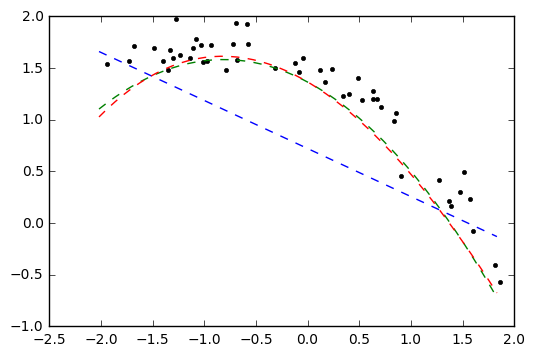

In [35]:
min_loss = np.Inf
# Try degree 1 to 3
pylab.plot(X_val, y_val, 'k.')
for deg in [1,2,3]:
    # Expand data first; you can check how this function works in utils.py
    X, C = degexpand(X_train, deg)
    y = y_train
        
    # Do gradient descent
    w, _ = gradDescent(X, y,10)
    loss = asymmLoss(X, w, y,10)
    val_loss = asymmLoss(degexpand(X_val, deg, C)[0], w, y_val,10)
    
    print('degree %d:' %(deg))
    print('train loss %.6f' %(loss))
    print('val loss %.6f' %(val_loss))
    print('sigma^2: %.6f \nlog-likelihood %.6f\n' %logLikelihood(X, w, y_train))
    

    
    if val_loss < min_loss:
        min_loss = val_loss
        best_param = (w, deg, C)
    
    # Plot the function
    color = {1:'b', 2:'g', 3:'r'}[deg]
    pylab.plot(np.linspace(min(X_train)-.1,max(X_train)+.1), np.dot(degexpand(np.linspace(min(X_train)-.1,max(X_train)+.1).reshape((50, 1)), deg, C)[0], w), color + '--')
    


In [45]:
# Announce result on test data
X_test, y_test = loadData('test')
print("Best degree:"+repr(best_param[1]))
#YOUR CODE HERE TO PRINT RELEVANT EVALUATION METRIC FOR THE CHOSEN MODEL
test_loss = asymmLoss(degexpand(X_test, best_param[1], best_param[2])[0],best_param[0], y_test,10)
print('test asymm loss %.6f' %(test_loss))


Best degree:2
test asymm loss 0.091735
